# Final Project


In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchani
import matplotlib.pyplot as plt

### Use GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Set up AEV computer

#### AEV: Atomic Environment Vector (atomic features)

Ref: Chem. Sci., 2017, 8, 3192

In [3]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


### Prepare dataset & split

In [4]:
def load_ani_dataset(dspath):
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("./ani_gdb_s01_to_s04.h5")
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.75, 0.1, 0.15)

### Batching

In [5]:
batch_size = 8192
# use dataset.collate(...).cache() method to do batching
train_data_loader = train_data.collate(batch_size).cache()
val_data_loader = val_data.collate(batch_size).cache()
test_data_loader = test_data.collate(batch_size).cache()

### Torchani API

In [12]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        #self.layers = nn.Sequential(
        #    nn.Linear(384, 128),
        #    nn.ReLU(),
        #    nn.Linear(128, 1)
        #)
        self.input = nn.Linear(384, 128)
        self.hidden = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.1)
        )
        self.output = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(64,10),
            nn.LeakyReLU(),
            nn.Linear(10,1)
        )
    
    def forward(self, x):
        #return self.layers(x)
        x = self.input(x)
        residual = x
        x = self.hidden(x)
        x = x + residual  # residual connection
        return self.output(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

### Train Class

In [13]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(batch_size).cache()
        
        # definition of loss function: MSE is a good choice! 
        loss_func = nn.MSELoss()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:

                train_spec = train_data_batch['species'].to(device)
                train_coords = train_data_batch['coordinates'].to(device)
                train_energies = train_data_batch['energies'].to(device).float()
                
                # compute energies
                _, pred = self.model((train_spec, train_coords))
                
                # compute loss
                batch_loss = loss_func(pred, train_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = train_energies.shape[0] / len(train_data)
                train_epoch_loss += batch_loss.detach().cpu().item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            ax.plot(np.arange(self.epoch), train_loss_list, label='Train')
            ax.plot(np.arange(self.epoch), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        self.model.eval()
        
        # init data loader
        data_loader = data.collate(batch_size).cache()
        
        # init loss function
        
        loss_func = nn.MSELoss()
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:

                data_spec = batch_data['species'].to(device)
                data_coords = batch_data['coordinates'].to(device)
                data_energies = batch_data['energies'].to(device).float()
                
                # compute energies
                _, pred = self.model((data_spec, data_coords))
                
                # compute loss
                batch_loss = loss_func(pred, data_energies)

                batch_importance = data_energies.shape[0] / len(train_data)
                total_loss += batch_loss.detach().cpu().item() * batch_importance

                true_energies = data_energies
                pred_energies = pred
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all*hartree2kcalmol - pred_energies_all*hartree2kcalmol))
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

Sequential - Number of parameters: 300372
Initialize training data...


100%|██████████| 200/200 [20:20<00:00,  6.10s/it]


1.8641118077174168e-06


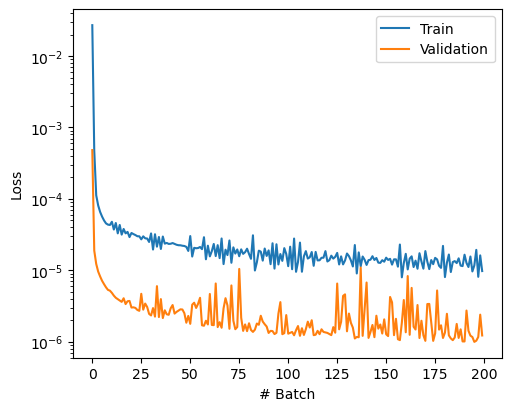

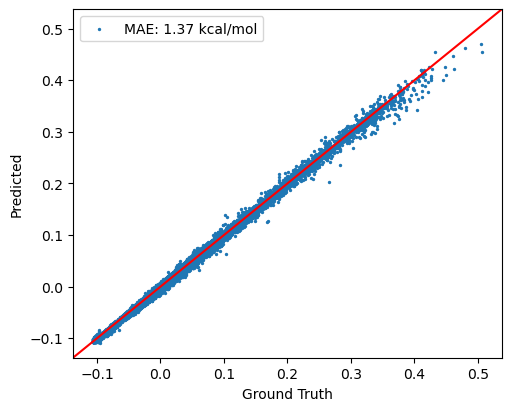

In [16]:
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)
trainer = ANITrainer(model, batch_size/2, 1e-4, 200, 1e-5)
trainer.train(train_data, val_data)
test_loss = trainer.evaluate(test_data, draw_plot=True)
print(test_loss)

In [22]:
'''
Regularization and Hyperparameter Tuning
normal 100 epoch full batch, lr=1e-3, l2=1e-5: 400MAE VERY BAD!!
100 epoch half batch, lr=1e-4, l2=1e-5/1e-7: 170MAE BAD!!!
Added a residual block 128->128 + 2 new hidden layers (Also switched to LeakyReLU): 1.97MAE GOOD!
Added Dropout and BatchNorm: 3.53MAE Still good with regularization!
150 epochs of learning: 2.24MAE Getting better
200 epochs of training: 1.37MAE training loss is seeming to plateau so no more epochs should be
trained on to avoid overfitting GOOD!!!
'''
print()